In [1]:
from lusidtools.jupyter_tools import toggle_code

"""Loading and caculating returns

Demonstration of how to load and calculate returns in LUSID.

Attributes
----------
Returns
"""

toggle_code("Toggle Docstring")

# Loading and calculating returns in LUSID

This notebook shows how you can load and calculate returns in LUSID. In the cells below, we load a CSV file of daily returns over a 5 year period (approximately). We then use LUSID to calculate various return metrics:

* Daily
* Since inception
* Week-to-date (WTD)
* Month-to-date (MTD)
* Quarter-to-date (QTD)
* Year-to-date (YTD)
* 1 month (1M)
* 3 months (3M)
* 1 Year (1Y)
* Since a specific date
* Annualised since incorporation
* 5 year annualised


# Setup LUSID

In [2]:
# Import general purpose packages
import os
import json
import pandas as pd
import numpy as np
import datetime
import pytz
import warnings

warnings.filterwarnings("ignore", module="matplotlib*")

import matplotlib.pyplot as plt

from datetime import datetime, timedelta

# Import lusid specific packages
import lusid
import lusid.models as models

from lusid.utilities import ApiClientFactory
from lusidjam.refreshing_token import RefreshingToken

# Set display configuration
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.set_option("display.max_rows", 3500)
pd.set_option("max_colwidth", 20)

# Use line magic function to enable matplotlib to work interactively with iPython
%matplotlib inline

# Set style to fivethirtyeight to create clean and clear looking graphs
plt.style.use("fivethirtyeight")

# Define a dictionary containing default plotting configurations
params = {
    "legend.fontsize": "small",
    "figure.figsize": (12, 4.5),
    "axes.labelsize": "small",
    "axes.titlesize": "medium",
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
}

plt.rcParams.update(params)

# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

# Initiate an API Factory which is the client side object for interacting with LUSID APIs
api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename=secrets_path,
    app_name="LusidJupyterNotebook",
)

api_status = pd.DataFrame(
    api_factory.build(lusid.api.ApplicationMetadataApi).get_lusid_versions().to_dict()
)

display(api_status)

,api_version,build_version,excel_version,links
0,v0,0.6.6650.0,0.5.2079,{'relation': 'Re...


In [3]:
# Define a scope to hold data

scope = "returns"
portfolio_code = "UK_EQUITY"

In [4]:
# Define the APIs we use

transaction_portfolios_api = api_factory.build(lusid.api.TransactionPortfoliosApi)
portfolios_api = api_factory.build(lusid.api.PortfoliosApi)

In [5]:
# Define dates
start_date = datetime(year=2020, month=1, day=2, tzinfo=pytz.UTC).isoformat
number_of_days = 366

# Load a DataFrame of returns from CSV file

In [6]:
returns_df = pd.read_csv("data/performance_data.csv", dtype={"daily_returns": np.int64})
returns_df["date"] = pd.to_datetime(returns_df["date"], format="%d/%m/%Y")
returns_df = returns_df.rename(
    columns={"mv": "market_value", "returns": "daily_returns"}
)

returns_df.head()

,date,market_value,daily_returns
0,2013-12-31,1000000.00000,0.00000
1,2014-01-01,993206.38000,-0.00679
2,2014-01-02,992628.45000,-0.00058
3,2014-01-03,996394.98000,0.00379
4,2014-01-04,1002500.97000,0.00613


# Create a portfolio

In [7]:
portfolios = [portfolio_code]

for port in portfolios:

    try:

        response = transaction_portfolios_api.create_portfolio(
            scope=scope,
            create_transaction_portfolio_request=models.CreateTransactionPortfolioRequest(
                display_name=port, code=port, created="2013-12-30", base_currency="GBP"
            ),
        )
    except lusid.ApiException as e:
        print(json.loads(e.body)["title"])

Could not create a portfolio with id UK_EQUITY because it already exists in scope returns.


# Upload returns into LUSID

> <b> NOTE: We have truncated the upsert to 10 rows. Remove the cell below if you want to load all 2500+ rows of daily returns.</b>

In [8]:
returns_df = returns_df[:10]

In [9]:
time_series_of_returns = [
    models.ModelReturn(
        effective_at=row["date"].isoformat()[:10],
        return_value=row["daily_returns"],
        market_value=row["market_value"],
        period="Daily",
    )
    for _, row in returns_df.iterrows()
]

In [10]:
return_code = "daily_return"

upsert_returns = portfolios_api.upsert_portfolio_returns(
    scope=scope,
    code=portfolio_code,
    return_code=return_code,
    return_scope=scope,
    model_return=time_series_of_returns,
)

# Retrieve returns from LUSID

In [11]:
from_effective_at = datetime(year=2013, month=12, day=31, tzinfo=pytz.utc).isoformat()
to_effective_at = datetime(year=2020, month=5, day=3, tzinfo=pytz.utc).isoformat()

returns = portfolios_api.get_portfolio_aggregate_returns(
    scope=scope,
    code=portfolio_code,
    return_code=return_code,
    return_scope=scope,
    from_effective_at=from_effective_at,
    to_effective_at=to_effective_at,
    period="Daily",
    output_frequency="Daily",
    metrics=[
        "1D",
        "INC",
        "WTD",
        "MTD",
        "QTD",
        "YTD",
        "1M",
        "3M",
        "1Y",
        "SINCE(2014-03-19)",
        "ANNUALISED(INC)",
        "ANNUALISED(5Y)",
    ],
)

In [12]:
data = returns.values

summary_df = pd.DataFrame(
    columns=[
        "date",
        "mv",
        "day",
        "inception",
        "mtd",
        "ytd",
        "qtd",
        "wtd",
        "1m",
        "3m",
        "1y",
        "since_20140319",
        "annualised_inc",
        "annualised_5y",
    ]
)

for item in data:

    row = {}
    row["date"] = item.effective_at.strftime(format="%Y-%m-%d")
    row["mv"] = item.market_value
    row["day"] = item.metrics_value["1D"]
    row["inception"] = item.metrics_value["INC"]
    row["mtd"] = item.metrics_value["MTD"]
    row["ytd"] = item.metrics_value["YTD"]
    row["qtd"] = item.metrics_value["QTD"]
    row["wtd"] = item.metrics_value["WTD"]
    row["1m"] = item.metrics_value["1M"]
    row["3m"] = item.metrics_value["3M"]
    row["1y"] = item.metrics_value["1Y"]
    row["since_20140319"] = item.metrics_value["SINCE(2014-03-19)"]
    row["annualised_inc"] = item.metrics_value["ANNUALISED(INC)"]
    row["annualised_5y"] = item.metrics_value["ANNUALISED(5Y)"]

    summary_df = summary_df.append(row, ignore_index=True)

In [13]:
summary_df.tail(10)

,date,mv,day,inception,mtd,ytd,qtd,wtd,1m,3m,1y,since_20140319,annualised_inc,annualised_5y
2246,2020-02-25,1805898.87000,-0.00250,0.80590,0.00248,0.08062,0.08062,-0.00403,-0.00174,0.17660,0.29449,0.81710,0.00029,0.06696
2247,2020-02-26,1811542.30000,0.00312,0.81154,0.00562,0.08400,0.08400,-0.00092,0.00666,0.18262,0.30644,0.82278,0.00029,0.06778
2248,2020-02-27,1816147.78000,0.00254,0.81615,0.00817,0.08675,0.08675,0.00162,0.01087,0.19505,0.32056,0.82742,0.00030,0.06858
2249,2020-02-28,1826811.17000,0.00587,0.82681,0.01409,0.09313,0.09313,0.00750,0.01681,0.20972,0.33724,0.83815,0.00030,0.07013
2250,2020-02-29,1844211.21000,0.00952,0.84421,0.02375,0.10355,0.10355,0.01710,0.02788,0.23243,0.34998,0.85565,0.00030,0.07216
2251,2020-03-01,1851992.27000,0.00422,0.85199,0.00422,0.10820,0.10820,0.02139,0.02992,0.25566,0.36695,0.86348,0.00031,0.07258
2252,2020-03-02,1853193.56000,0.00065,0.85319,0.00487,0.10892,0.10892,0.00065,0.02997,0.25405,0.37962,0.86469,0.00031,0.07216
2253,2020-03-03,1852655.21000,-0.00029,0.85266,0.00458,0.10860,0.10860,0.00036,0.02853,0.24866,0.38961,0.86415,0.00031,0.07181
2254,2020-03-04,1848853.84000,-0.00205,0.84885,0.00252,0.10632,0.10632,-0.00169,0.02561,0.23931,0.39419,0.86033,0.00030,0.07230
2255,2020-03-05,1847081.89000,-0.00096,0.84708,0.00156,0.10526,0.10526,-0.00265,0.01966,0.23065,0.40488,0.85854,0.00030,0.07286


In [14]:
def time_series_performance():
    ts_performance = summary_df.plot(y=["inception"], figsize=(12, 9))
    ts_performance.set_title(
        f"Performance of {portfolio_code} since inception",
        fontsize="large",
    )
    ts_performance.set_ylabel("Performance in %", fontsize="large")
    ts_performance.set_xlabel("Days since inception", fontsize="large")
    ts_performance.legend(prop={"size": 12})

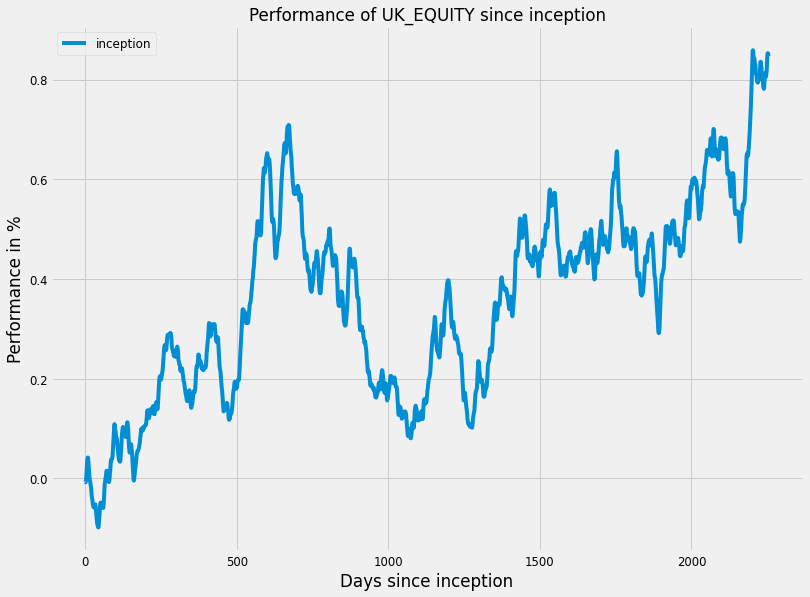

In [15]:
time_series_performance()